*Setting up the environment and loading the data.*

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Set Up Environment / Select data

In [65]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette('colorblind')

# Load the dataset
df = pd.read_csv('fraud.csv')



In [66]:
# Initial examination of the data
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
df.head()

Dataset shape: (498121, 10)

First few rows of the dataset:


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429,0
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259,0
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000,0
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857,0
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526,0


# 2. Data Cleaning

### Missing values

In [67]:
# Check for missing values
print("\nMissing Values:")
display(df.isnull().sum())



Missing Values:


,0
trustLevel,0
totalScanTimeInSeconds,0
grandTotal,0
lineItemVoids,0
scansWithoutRegistration,0
quantityModifications,0
scannedLineItemsPerSecond,0
valuePerSecond,0
lineItemVoidsPerPosition,0
fraud,0


## Handle duplicates

In [68]:
# Handle duplicates
duplicates = df.duplicated().sum()
print(f'Number of duplicate rows: {duplicates}')
df = df.drop_duplicates()

Number of duplicate rows: 0


## Visualize outliers -> Necessary?

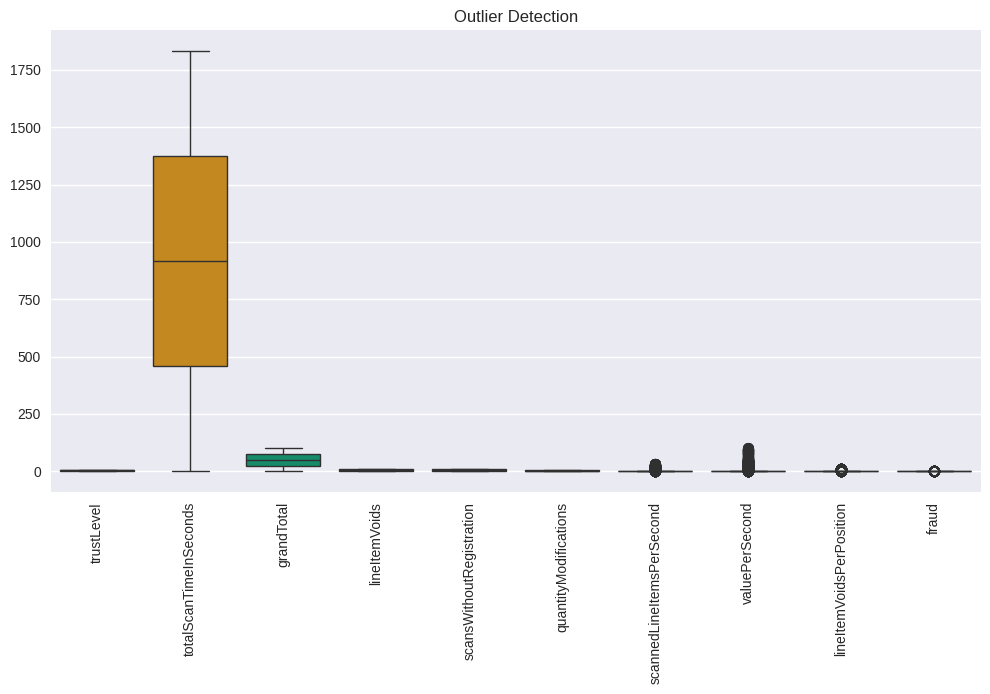

In [69]:
# Visualizing outliers using boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.select_dtypes(include=[np.number]))
plt.xticks(rotation=90)
plt.title("Outlier Detection")
plt.show()

# 3. Constructing Data

## Create Derived Features

Scanefficiency -> Does this make sense?

In [71]:
df["scanEfficiency"] = df["scannedLineItemsPerSecond"] * df["valuePerSecond"]

fraudactivityscore? -> Does this make sense?

In [72]:
# 'lineItemVoids' and 'scansWithoutRegistration' indicate potential fraud risk.
# We create 'fraudActivityScore' as their product to highlight transactions with both issues.
df["fraudActivityScore"] = df["lineItemVoids"] * df["scansWithoutRegistration"]

## Binning

In [73]:
# 'grandTotal' is binned to categorize transaction amounts.
df["grandTotal_category"] = pd.cut(df["grandTotal"], bins=[0, 20, 100, np.inf], labels=["Low", "Medium", "High"])
amount_dummies = pd.get_dummies(df["grandTotal_category"], prefix="grandTotal_amount")
df = pd.concat([df, amount_dummies], axis=1)
df = df.drop("grandTotal_category", axis=1)

In [74]:
# 'totalScanTimeInSeconds' is binned to classify checkout times.
df["scanTime_category"] = pd.cut(df["totalScanTimeInSeconds"], bins=[0, 300, 900, np.inf], labels=["Short", "Medium", "Long"])
amount_dummies = pd.get_dummies(df["scanTime_category"], prefix="scanTime_length")
df = pd.concat([df, amount_dummies], axis=1)
df = df.drop("scanTime_category", axis=1)

## **Datasets**



### As-Is Dataset (with derived + binning)

In [75]:
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
df.head()

Dataset shape: (498121, 18)

First few rows of the dataset:


,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition,fraud,scanEfficiency,fraudActivityScore,grandTotal_amount_Low,grandTotal_amount_Medium,grandTotal_amount_High,scanTime_length_Short,scanTime_length_Medium,scanTime_length_Long
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429,0,0.002840,32,False,True,False,False,True,False
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259,0,0.001580,42,False,True,False,False,False,True
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000,0,0.000533,20,True,False,False,True,False,False
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857,0,0.004194,27,False,True,False,False,True,False
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526,0,0.001011,0,False,True,False,False,True,False


### Balanced Dataset (50-50)

In [76]:
# Create a balanced dataset with 50% fraud and 50% non-fraud
def create_balanced_dataset(df, target_column='fraud'):
    # Make a copy of the original dataframe
    df_balanced = df.copy()

    # Separate fraud and non-fraud instances
    fraud_df = df_balanced[df_balanced[target_column] == 1]
    non_fraud_df = df_balanced[df_balanced[target_column] == 0]

    # Get counts
    n_fraud = len(fraud_df)
    n_non_fraud = len(non_fraud_df)

    # Determine the smaller class size
    min_count = min(n_fraud, n_non_fraud)

    # Print original distribution
    print(f"Original distribution:")
    print(f"Fraud cases: {n_fraud} ({n_fraud/len(df)*100:.2f}%)")
    print(f"Non-fraud cases: {n_non_fraud} ({n_non_fraud/len(df)*100:.2f}%)")

    # Sample from the larger class to match the smaller class
    if n_fraud < n_non_fraud:
        # Downsample non-fraud cases
        non_fraud_downsampled = non_fraud_df.sample(n=n_fraud, random_state=1) #Always results in same "random" dataset because of seed 1
        # Combine with all fraud cases
        df_balanced = pd.concat([fraud_df, non_fraud_downsampled])
    else:
        # Downsample fraud cases
        fraud_downsampled = fraud_df.sample(n=n_non_fraud, random_state=1) #Always results in same "random" dataset because of seed 1
        # Combine with all non-fraud cases
        df_balanced = pd.concat([fraud_downsampled, non_fraud_df])

    # Shuffle the data
    df_balanced = df_balanced.sample(frac=1, random_state=1).reset_index(drop=True)

    # Print new distribution
    n_fraud_new = len(df_balanced[df_balanced[target_column] == 1])
    n_non_fraud_new = len(df_balanced[df_balanced[target_column] == 0])

    print(f"\nDistribution after balancing:")
    print(f"Fraud cases: {n_fraud_new} ({n_fraud_new/len(df_balanced)*100:.2f}%)")
    print(f"Non-fraud cases: {n_non_fraud_new} ({n_non_fraud_new/len(df_balanced)*100:.2f}%)")
    print(f"Total dataset size: {len(df_balanced)} rows")

    return df_balanced

# Create balanced dataset
df_balanced = create_balanced_dataset(df)

# Save to CSV
df_balanced.to_csv("dataset_balanced.csv", index=False)

Original distribution:
Fraud cases: 23727 (4.76%)
Non-fraud cases: 474394 (95.24%)

Distribution after balancing:
Fraud cases: 23727 (50.00%)
Non-fraud cases: 23727 (50.00%)
Total dataset size: 47454 rows


### Outlier-Removed Dataset (Removed Q4 ONLY for totalScanTime/Removed Outliers)

Han do mol e "aggressivi" version vom outlier removing spezifisch nur für totalscantime gmacht. wil die lange scan times (30 min etc.) werde nit vom normale outlier removing (IQR-based) entfernt, will sie halt no in dr IQR sind.  

Unte isch die "standard" outlier removal function.

In [77]:
df_no_q4 = df.copy()

# Function to remove the upper quartile (Q4, or values above Q3)
def remove_upper_quartile(data, column):
    original_shape = data.shape[0]

    # Calculate Q3 (75th percentile)
    Q3 = data[column].quantile(0.75)

    # Filter to keep only values below or equal to Q3
    filtered_data = data[data[column] <= Q3]

    # Print information about the removal
    removed_count = original_shape - filtered_data.shape[0]
    removed_percentage = (removed_count / original_shape) * 100

    print(f"Removed {removed_count} rows ({removed_percentage:.2f}% of data)")
    print(f"Original range: [{data[column].min():.2f}, {data[column].max():.2f}]")
    print(f"New range: [{filtered_data[column].min():.2f}, {filtered_data[column].max():.2f}]")

    return filtered_data

# Apply the function to remove upper quartile of totalScanTimeInSeconds
df_no_q4 = remove_upper_quartile(df_no_q4, "totalScanTimeInSeconds")
print()
df_no_q4_balanced = create_balanced_dataset(df_no_q4)
# Save the transformed dataset
df_no_q4.to_csv("dataset_no_q4_scantime.csv", index=False)

Removed 124453 rows (24.98% of data)
Original range: [1.00, 1831.00]
New range: [1.00, 1374.00]

Original distribution:
Fraud cases: 14060 (3.76%)
Non-fraud cases: 359608 (96.24%)

Distribution after balancing:
Fraud cases: 14060 (50.00%)
Non-fraud cases: 14060 (50.00%)
Total dataset size: 28120 rows


In [78]:
df_no_outliers = df.copy()

# Simplified function to track outliers by column
def drop_outliers(data, columns):
    original_shape = data.shape[0]
    original_data = data.copy()

    # Track removals per column
    removal_stats = {}

    for col in columns:
        before_count = data.shape[0]

        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Count outliers before filtering
        lower_outliers = data[data[col] < lower_bound].shape[0]
        upper_outliers = data[data[col] > upper_bound].shape[0]

        # Filter the dataframe to remove outliers
        data = data[(data[col] >= lower_bound) & (data[col] <= upper_bound)]

        after_count = data.shape[0]
        removed = before_count - after_count

        removal_stats[col] = {
            'total_removed': removed,
            'below_lower_bound': lower_outliers,
            'above_upper_bound': upper_outliers,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'min_value': original_data[col].min(),
            'max_value': original_data[col].max(),
            'new_min': data[col].min(),
            'new_max': data[col].max()
        }

    # Print detailed statistics
    print(f"Original dataset size: {original_shape} rows")
    print(f"Final dataset size: {data.shape[0]} rows")
    print(f"Total rows removed: {original_shape - data.shape[0]} ({(original_shape - data.shape[0])/original_shape:.2%} of data)")
    print("\nRemoval details by column:")

    for col, stats in removal_stats.items():
        print(f"\n{col}:")
        print(f"  Original range: [{stats['min_value']:.2f}, {stats['max_value']:.2f}]")
        print(f"  New range: [{stats['new_min']:.2f}, {stats['new_max']:.2f}]")
        print(f"  Outlier bounds: [{stats['lower_bound']:.2f}, {stats['upper_bound']:.2f}]")
        print(f"  Outliers below: {stats['below_lower_bound']} rows")
        print(f"  Outliers above: {stats['above_upper_bound']} rows")
        print(f"  Total removed: {stats['total_removed']} rows")

    return data

# Define numeric columns to process (excluding totalScanTimeInSeconds)
numeric_cols = [col for col in df.select_dtypes(include=['number']).columns if col != 'fraud']

# Apply the function to our numeric columns
df_no_outliers = drop_outliers(df_no_outliers, numeric_cols)
df_no_outliers_balanced = create_balanced_dataset(df_no_outliers)
# Save the transformed dataset
df_no_outliers.to_csv("dataset_no_outliers.csv", index=False)

Original dataset size: 498121 rows
Final dataset size: 320214 rows
Total rows removed: 177907 (35.72% of data)

Removal details by column:

trustLevel:
  Original range: [1.00, 6.00]
  New range: [1.00, 6.00]
  Outlier bounds: [-2.50, 9.50]
  Outliers below: 0 rows
  Outliers above: 0 rows
  Total removed: 0 rows

totalScanTimeInSeconds:
  Original range: [1.00, 1831.00]
  New range: [1.00, 1831.00]
  Outlier bounds: [-916.00, 2748.00]
  Outliers below: 0 rows
  Outliers above: 0 rows
  Total removed: 0 rows

grandTotal:
  Original range: [0.00, 99.99]
  New range: [0.00, 99.99]
  Outlier bounds: [-50.20, 150.15]
  Outliers below: 0 rows
  Outliers above: 0 rows
  Total removed: 0 rows

lineItemVoids:
  Original range: [0.00, 11.00]
  New range: [0.00, 11.00]
  Outlier bounds: [-4.50, 15.50]
  Outliers below: 0 rows
  Outliers above: 0 rows
  Total removed: 0 rows

scansWithoutRegistration:
  Original range: [0.00, 10.00]
  New range: [0.00, 10.00]
  Outlier bounds: [-7.00, 17.00]
  Ou

### List of datasets

In [79]:
datasets = {
    "Original Data": df,
    "Balanced Data": df_balanced,
    "No Q4 Data": df_no_q4,
    "No Q4 Balanced Data": df_no_q4_balanced,
    "No Outliers Data": df_no_outliers,
    "No Outliers Balanced Data": df_no_outliers_balanced
}

# 4. Integrate Data : N/A
We have only one data source

# 5. Format data - After Feature Reduction etc. -> Model-specific

# MODEL Random Forrest

In [ ]:
print("\n--- Model Training and Evaluation ---")

for name,_df in datasets.items():
  dataset = _df
  print(f"\n\n========== EVALUATING: {name} ==========")

  # Use the reduced dataset
  X = dataset.drop('fraud', axis=1)
  y = dataset['fraud']

  print("\nAll features used in the full model:")
  print(X.columns.tolist())

  # Split the data
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

  print(f"Training set shape: {X_train.shape}")
  print(f"Testing set shape: {X_test.shape}")

  # Train the Random Forest model
  rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
  rf_model.fit(X_train, y_train)

  # Make predictions
  y_pred = rf_model.predict(X_test)
  y_prob = rf_model.predict_proba(X_test)[:, 1]  # Probability of the positive class

  # Evaluate the model
  accuracy = accuracy_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_prob)
  conf_matrix = confusion_matrix(y_test, y_pred)

  print(f"\nAccuracy: {accuracy:.4f}")
  print(f"ROC AUC: {auc:.4f}")

  print("\nConfusion Matrix:")
  print(conf_matrix)

  # Calculate additional metrics
  tn, fp, fn, tp = conf_matrix.ravel()
  sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
  specificity = tn / (tn + fp)  # True Negative Rate
  precision = tp / (tp + fp)
  f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

  print(f"\nSensitivity (TPR): {sensitivity:.4f}")
  print(f"Specificity (TNR): {specificity:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"F1 Score: {f1:.4f}")

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))


--- Model Training and Evaluation ---


========== EVALUATING: Original Data ==========

All features used in the full model:
['trustLevel', 'totalScanTimeInSeconds', 'grandTotal', 'lineItemVoids', 'scansWithoutRegistration', 'quantityModifications', 'scannedLineItemsPerSecond', 'valuePerSecond', 'lineItemVoidsPerPosition', 'scanEfficiency', 'fraudActivityScore', 'grandTotal_amount_Low', 'grandTotal_amount_Medium', 'grandTotal_amount_High', 'scanTime_length_Short', 'scanTime_length_Medium', 'scanTime_length_Long']
Training set shape: (348684, 17)
Testing set shape: (149437, 17)

Accuracy: 0.9942
ROC AUC: 0.9994

Confusion Matrix:
[[142074    245]
 [   620   6498]]

Sensitivity (TPR): 0.9129
Specificity (TNR): 0.9983
Precision: 0.9637
F1 Score: 0.9376

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    142319
           1       0.96      0.91      0.94      7118

    accuracy                           0.99    149